# Initialization

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import os, cv2, sys
import time
sys.path.append("..")
from models.yolo_models import get_yolo
%matplotlib inline

Using TensorFlow backend.
/home/staff1/ctorney/python3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [ ]:

anchors = [53.57159857, 42.28639429, 29.47927551, 51.27168234, 37.15496912, 26.17125211]
obj_thresh=0.5
nms_thresh=0.25

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3          

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))


def bbox_iou(box1, box2):
    
    intersect_w = _interval_overlap([box1[0], box1[2]], [box2[0], box2[2]])
    intersect_h = _interval_overlap([box1[1], box1[3]], [box2[1], box2[3]])
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1[2]-box1[0], box1[3]-box1[1]
    w2, h2 = box2[2]-box2[0], box2[3]-box2[1]
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

In [2]:

IMAGE_H, IMAGE_W = 4928//2, 7360//2
model = get_yolo(IMAGE_W,IMAGE_H)

model.load_weights('../weights/wb_yolo.h5')

In [3]:
image_dir = '../../data/2015/'
image_name = image_dir + 'SWC1077.JPG'
img = cv2.imread(image_name)#1077.JPG') #1149.JPG')

img = img[0:IMAGE_H, 0:IMAGE_W,:]
input_image = cv2.resize(img, (IMAGE_W, IMAGE_H))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)


In [38]:

import time
startall = time.time()
start = time.time()
netout = model.predict(input_image)[0]
end = time.time()
print('pred', end - start)

start = time.time()

anchors = [53.57159857, 42.28639429, 29.47927551, 51.27168234, 37.15496912, 26.17125211]
obj_thresh=0.5
nms_thresh=0.25


def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

grid_h, grid_w = netout.shape[:2]
nb_box=3
netout = netout.reshape(grid_h,grid_w,nb_box,-1)

nb_class = netout.shape[-1] - 5

boxes = []

netout[..., :2]  = _sigmoid(netout[..., :2])
netout[..., 4:]  = _sigmoid(netout[..., 4:])
netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]


for row in range(grid_h):
    for col in range(grid_w):
        
        for b in range(nb_box):
            #wildebeest score
            objectness = netout[int(row)][int(col)][b][5]
                #objectness = netout[..., :4]

            if(objectness <= obj_thresh): continue

            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]

            x = (col + x) * IMAGE_W / grid_w # center position, unit: image px
            y = (row + y) * IMAGE_H / grid_h # center position, unit: image px
            w = anchors[2 * b + 0] * np.exp(w)  # unit: image px
            h = anchors[2 * b + 1] * np.exp(h) # unit: image px  
            
            box = [x-w/2, y-h/2, x+w/2, y+h/2, objectness]


            boxes.append(box)

end = time.time()
print('boxes', end - start)

start = time.time()


sorted_indices = np.argsort([-box[4] for box in boxes])
end = time.time()
print('sort', end - start)

start = time.time()
for i in range(len(sorted_indices)):
    index_i = sorted_indices[i]

    if boxes[index_i][4] == 0: continue

    for j in range(i+1, len(sorted_indices)):
        index_j = sorted_indices[j]
        #start = time.time()
        
        if bbox_iou(boxes[index_i][0:4], boxes[index_j][0:4]) >= nms_thresh:
            boxes[index_j][4] = 0
        #end = time.time()
        #print('nmsing', end - start)
end = time.time()
print('zero', end - start)

start = time.time()
final_boxes=[]
for b in boxes:
    if b[4]>0:
        final_boxes.append(b)
end = time.time()
print('remove', end - start)


print('-------')
print('all', end - startall)


pred 1.1377389430999756
boxes 2.0904428958892822
sort 0.0009620189666748047
zero 2.5065126419067383
remove 0.0015177726745605469
-------
all 5.737953186035156


In [37]:

import time
startall = time.time()
start = time.time()
netout = model.predict(input_image)[0]
end = time.time()
print('pred', end - start)

start = time.time()

anchors = [53.57159857, 42.28639429, 29.47927551, 51.27168234, 37.15496912, 26.17125211]
obj_thresh=0.5
nms_thresh=0.25


def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

grid_h, grid_w = netout.shape[:2]
nb_box=3
netout = netout.reshape(grid_h,grid_w,nb_box,-1)

nb_class = netout.shape[-1] - 5

boxes = []

netout[..., :2]  = _sigmoid(netout[..., :2])
netout[..., 4:]  = _sigmoid(netout[..., 4:])
netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]

x = np.linspace(0, grid_w-1, grid_w)
y = np.linspace(0, grid_h-1, grid_h)

xv,yv = np.meshgrid(x, y)
xv = np.expand_dims(xv, -1)
yv = np.expand_dims(yv, -1)
xpos =(np.tile(xv, (1,1,3))+netout[...,0]) * IMAGE_W / grid_w 
ypos =(np.tile(yv, (1,1,3))+netout[...,1]) * IMAGE_H / grid_h
wpos = np.exp(netout[...,2])
hpos = np.exp(netout[...,3])
anchors1 = np.array([[53.57159857, 42.28639429], [29.47927551, 51.27168234], [37.15496912, 26.17125211]])

for b in range(nb_box):
    wpos[...,b] *= anchors1[b,0]
    hpos[...,b] *= anchors1[b,1]

objectness = netout[...,5]
indexes = objectness > obj_thresh



new_boxes = np.column_stack((xpos[indexes]-wpos[indexes]/2, \
                             ypos[indexes]-hpos[indexes]/2, \
                             xpos[indexes]+wpos[indexes]/2, \
                             ypos[indexes]+hpos[indexes]/2, \
                             objectness[indexes]))


end = time.time()
print('boxes', end - start)

start = time.time()
sorted_indices = np.argsort(-new_boxes[:,4])
end = time.time()
print('sort', end - start)
boxes=new_boxes.tolist()
start = time.time()
for i in range(len(sorted_indices)):
    index_i = sorted_indices[i]

    if new_boxes[index_i,4] == 0: continue

    for j in range(i+1, len(sorted_indices)):
        index_j = sorted_indices[j]
        #start = time.time()
        #if bbox_iou2(new_boxes[index_i],new_boxes[index_j]) >= nms_thresh:
        if bbox_iou(boxes[index_i][0:4], boxes[index_j][0:4]) >= nms_thresh:
            new_boxes[index_j,4] = 0
end = time.time()
print('zero', end - start)

start = time.time()

new_boxes = new_boxes[new_boxes[:,4]>0]
end = time.time()
print('remove', end - start)
print('-------')
print('all', end - startall)


pred 1.1417179107666016
boxes 0.08771419525146484
sort 0.0005068778991699219
zero 1.7600574493408203
remove 0.00032019615173339844
-------
all 2.99172043800354


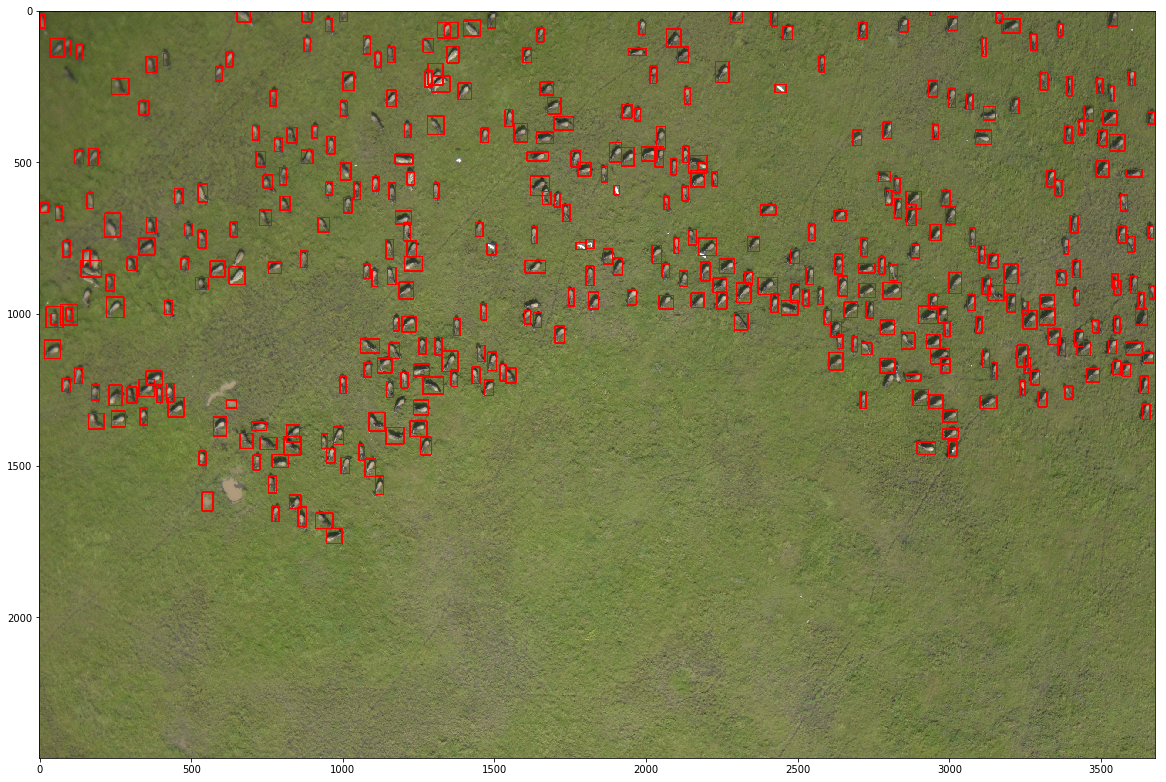

In [39]:


img = cv2.imread(image_name)#1077.JPG') #1149.JPG')


image = img[0:IMAGE_H, 0:IMAGE_W,:]

for box in new_boxes:
    xmin  = int((box[0]))
    xmax  = int((box[2]))
    ymin  = int((box[1]))
    ymax  = int((box[3]))

    cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,0,255), 3)
plt.figure(figsize=(20,20))
plt.imshow(image[:,:,::-1])
plt.show()
